In [1]:
import numpy as np
import  json
from  shapely.geometry  import Polygon, Point
import shapely.ops as shops
#from descartes.patch import PolygonPatch
import shapely.vectorized
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr
import hvplot.xarray
import pandas as pd
from IPython.display import display, HTML
from scipy import interpolate, signal
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
%matplotlib inline

### Load in the stack of elevation maps
These maps are in rotated cross-shore and alongshore coordinates.
They were generated by Sandwich_maps_local_coords.ipynb


In [2]:
titles = ([\
         "22-Jan-2016",\
         "25-Jan-2016",\
         "11-Feb-2016",\
         "30-Mar-2016",\
         "21-Sep-2016",\
         "09-Jan-2017",\
         "25-Jan-2017",\
         "14-Feb-2017",\
         "16-Mar-2017",\
         "28-Apr-2017",\
         "04-May-2017",\
         "18-Sep-2017",\
#         "03-Jan-2017",\
         "10-Jan-2018",\
         "09-Mar-2018"]
         )

# make a array of time differences between surveys
dt = np.array([ datetime.strptime(titles[i], '%d-%b-%Y') for i in range (len(titles))])
dtt=dt-dt[0]
dts = np.array([dtt[i].total_seconds() for i in range(len(titles))])
dts

array([        0.,    259200.,   1728000.,   5875200.,  20995200.,
        30499200.,  31881600.,  33609600.,  36201600.,  39916800.,
        40435200.,  52272000.,  62121600.,  67132800.])

In [3]:
da = xr.open_dataarray('one_meter_test.nc')
(num_maps,ysize,xsize)=np.shape(da.values)
print('Shape of stacked elevation array: ',num_maps,xsize,ysize)

# use meshgrid to make coordinate arrays
X, Y = np.meshgrid( da.coords['Cross-shore'].values, da.coords['Alongshore'].values )
print('Shape of X and Y',np.shape(X),np.shape(Y))
da

Shape of stacked elevation array:  14 280 1300
Shape of X and Y (1300, 280) (1300, 280)


<xarray.DataArray (map: 14, Alongshore: 1300, Cross-shore: 280)>
array([[[ -3.276700e+04,  -3.276700e+04, ...,  -9.668977e-01,  -9.762037e-01],
        [ -3.276700e+04,  -3.276700e+04, ...,  -9.760453e-01,  -9.674652e-01],
        ..., 
        [           nan,            nan, ...,            nan,            nan],
        [           nan,            nan, ...,            nan,            nan]],

       [[ -3.276700e+04,  -3.276700e+04, ...,            nan,            nan],
        [ -3.276700e+04,  -3.276700e+04, ...,            nan,            nan],
        ..., 
        [           nan,            nan, ...,            nan,            nan],
        [           nan,            nan, ...,            nan,            nan]],

       ..., 
       [[           nan,            nan, ...,  -3.276700e+04,  -3.276700e+04],
        [           nan,            nan, ...,  -3.276700e+04,  -3.276700e+04],
        ..., 
        [           nan,            nan, ...,  -3.276700e+04,  -3.276700e+04],
       

### Plot one of the elevation layers to make sure coords are correct

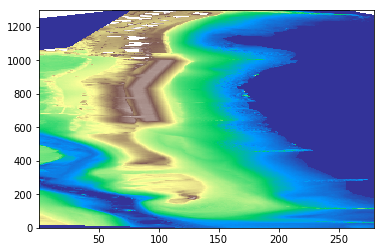

In [4]:
plt.pcolormesh(X, Y, np.squeeze(da[0,:,:]), vmin=-2,vmax=8,cmap=plt.cm.terrain )

### Use json to read in the ROI polygon (drawn in Global mapper, and saved in geojson format)
Use the coordinates to convert to a shapely polygon

Area of polygon: Barrier ROI: 269433.9 m^2


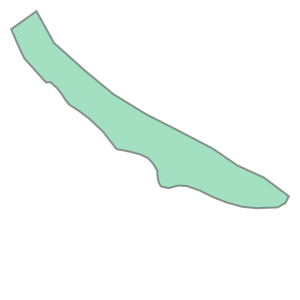

In [5]:
# read the barrier roi
with open('barrier_roi.geojson') as f:
    data = json.load(f)

    # assume there is only one feature, extract coordinates, and convert to array
    a=np.squeeze( data['features'][0]['geometry']['coordinates'] )

    # make a shapely.geometry.Polygon, which requires a sequence of coordinate tuples
    barrier_roi_poly = Polygon(tuple(map(tuple,a)))
    xc=barrier_roi_poly.centroid.x
    yc=barrier_roi_poly.centroid.y
    print("Area of polygon: {} {:.1f} m^2".format('Barrier ROI:',barrier_roi_poly.area))

barrier_roi_poly

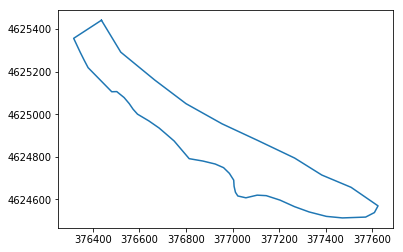

In [6]:
# could extract the UTM boundaries from the polygon, but they are already in a
# xx, yy = barrier_roi_poly.exterior.coords.xy
# xxx=np.array(xx)
# yyy=np.array(yy)
# print(xxx, yyy)
xxx = a[:,0]
yyy = a[:,1]
plt.plot(xxx,yyy)

In [7]:
# This is the function I used to convert box coordinates to UTM
def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        xr, yr - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),\
                   (0., 1., y0),\
                   (0., 0., 1.)))
    
    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    xr = xyrh[0,:]
    yr = xyrh[1,:]
    return xr, yr

### Test cell to check conversion from UTM to box (cross-shore, alongshore) coordinates

[ 377270.          376245.58602031  376417.9712334   377442.38521309] [ 4624440.          4625240.35991792  4625461.00292893  4624660.64301101]
[  0.00000000e+00   3.69368536e-10   2.80000000e+02   2.80000000e+02] [  0.00000000e+00   1.30000000e+03   1.30000000e+03   2.05233164e-10]


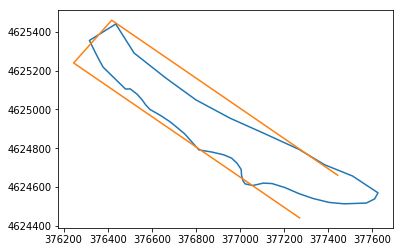

In [8]:
# These values must match those used to define the box in Sandwich_maps_local_coords.ipynb
x0 = 377270.; y0 = 4624440.
theta = 52.

# here are the local coordinates of corners of the box
xb = np.array((0., 0., 280., 280.))
yb = np.array((0., 1300., 1300., 0.))

# convert to UTM
xr,yr = box2UTMh(xb, yb, x0, y0,theta)
print(xr,yr)

# invert back to box as a check (remove offset first, then reverse rotation)
xur,yur = box2UTMh(xr-x0, yr-y0, 0., 0., -theta)
print(xur,yur)

# plot the box overlaid on roi in local coordinates
plt.plot(xxx,yyy)
plt.plot(xr,yr)

### Define an inverse function for shapely to convert from UTM to local cross-shelf / alongshore coord system

In [9]:
def UTM2box_func(x, y, z=None):
    '''
    Implement coordinate transformation used to rotate DEMs to box ROI
    I am not sure how to pass arguments to this through shapely,
    so make sure that x0, y0, and theta are same as used in
    box2UTMh(x, y, x0, y0, theta)
    
    This function first removes the offset, then does a reverse rotation using
    the hard-wired values.
    '''
    x0 = 377270.; y0 = 4624440.
    theta = 52.
    
    x = x-x0
    y = y-y0
    
    thetar = np.radians(theta)
    c, s = np.cos(-thetar), np.sin(-thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix (not really needed in this inverse transform)
    Th = np.array(((1., 0., 0.),\
                   (0., 1., 0.),\
                   (0., 0., 1.)))
    
    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    
    # overwrite input arrays
    x = xyrh[0,:]
    y = xyrh[1,:]
    
    # return tuple(filter(None, [x, y, z])) # complains about ambiguous
    return (x,y)

### Transform the UTM polygon to rotated coords

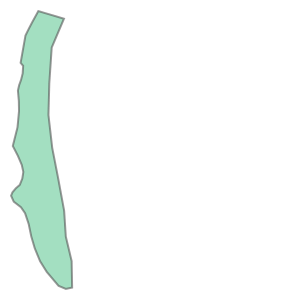

In [10]:
# This calls the inverse transform function
roi=shops.transform(UTM2box_func,barrier_roi_poly)
roi

In [11]:
xx, yy = roi.exterior.coords.xy
xx

array('d', [276.0229760136282, 135.57810953934484, 101.29743643240761, 81.93558148092347, 65.16617852985644, 38.548752604862216, 52.40370026319715, 49.83164108386757, 40.921116986020024, 30.408652062330418, 23.77263655070982, 28.810814274324343, 29.654599959217705, 26.340674189354957, 21.37589956502103, -4.271408622115985, 23.17761730111863, 44.92406250265054, 53.45144722002979, 47.76926010684517, 34.12221174525541, 12.2168150140497, -6.248283713488576, -13.61393915855217, 0.9584209893675393, 40.62783348091895, 62.84711190475376, 82.74297450270248, 96.91180306546637, 116.04134356880095, 145.2798188152696, 181.9777032245951, 246.52814497128057, 286.5521824224913, 320.9225471806283, 318.2363012793755, 286.23415751118546, 277.184992591934, 244.95049402148567, 211.73771233672065, 191.0388081106127, 195.74267158280207, 209.00243576811232, 276.0229760136282])

In [12]:
# check nan calcs
a = np.array([np.NaN, 3.])
b = np.array([1., 2.])
print(a,b)
print(a+b)

[ nan   3.] [ 1.  2.]
[ nan   5.]


In [13]:
### Make a mask to NaN out regions outside the barrier roi

## key parameter: mask elevation:
# mel = -0.2 # mllw
mnel = -0.2
mxel =  2.9

mask = np.empty((ysize,xsize))
print('Shape of mask: ',np.shape(mask))
# raster mask
mask[:,:] = shapely.vectorized.contains(roi,X,Y)

mask[mask==0.]=np.NaN

# copy the DataArray
dam = da.copy()

# make masked 3d array
for imapn in range(0,14):
    dam[imapn,:,:]=np.squeeze(dam[imapn,:,:]*mask)
    
dam = dam.where(dam>mnel)
    
# make an anomaly array
damean = np.mean(dam,0)
daanom = da.copy()
for imapn in range(0,14):
    daanom[imapn,:,:]=np.squeeze(dam[imapn,:,:]-damean)
    
# make an differnce array
damean = np.mean(dam,0)
dadiff = dam.copy()
for imapn in range(0,13):
    dadiff[imapn,:,:]=np.squeeze(dam[imapn+1,:,:]-dam[imapn,:,:])
dadiff[13,:,:]=np.squeeze(dam[13,:,:]-dam[0,:,:])

Shape of mask:  (1300, 280)


In [14]:
# make a dune-masked 3d array
dune = dam.copy()
for imapn in range(0,14):
    dunei = np.squeeze(dune[imapn,:,:]*mask)
    dmask=mask.copy()
    dmask[dunei<=mxel]=np.NaN
    dune[imapn,:,:]=dunei*dmask
    
# make a beach-masked 3d array
beach = dam.copy()
for imapn in range(0,14):
    beachi = np.squeeze(dune[imapn,:,:]*mask)
    bmask=mask.copy()
    bmask[dunei>mxel]=np.NaN
    beach[imapn,:,:]=beachi*bmask

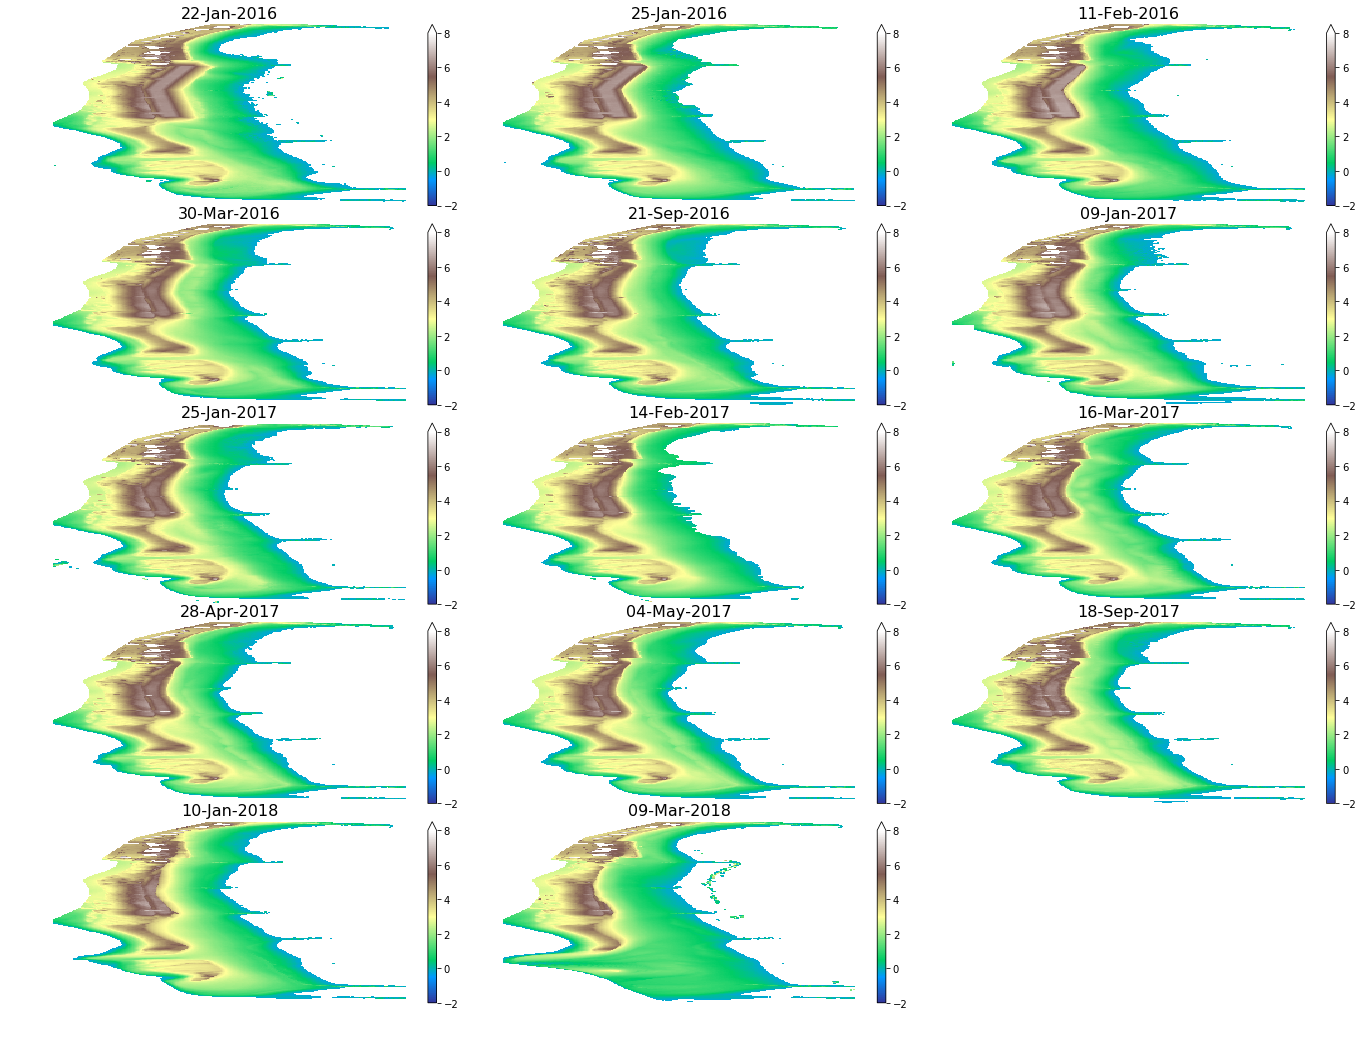

In [45]:
# look at each map, and anomoly, and difference
m = dam.copy()
plt.subplots(figsize=(24,18))
plt.subplots_adjust(hspace=0.1, wspace=0.02)

for imapn in range(0,14):
    # small plots of elevation
    plt.subplot(5,3,imapn+1)
    plt.axis('off')
    mi = np.squeeze(m[imapn,:,:])
    mi.plot(vmin=-2,vmax=8,cmap=plt.cm.terrain)
    plt.title(titles[imapn],fontsize=16)
        
plt.savefig('masked_elevation_time_series.png')

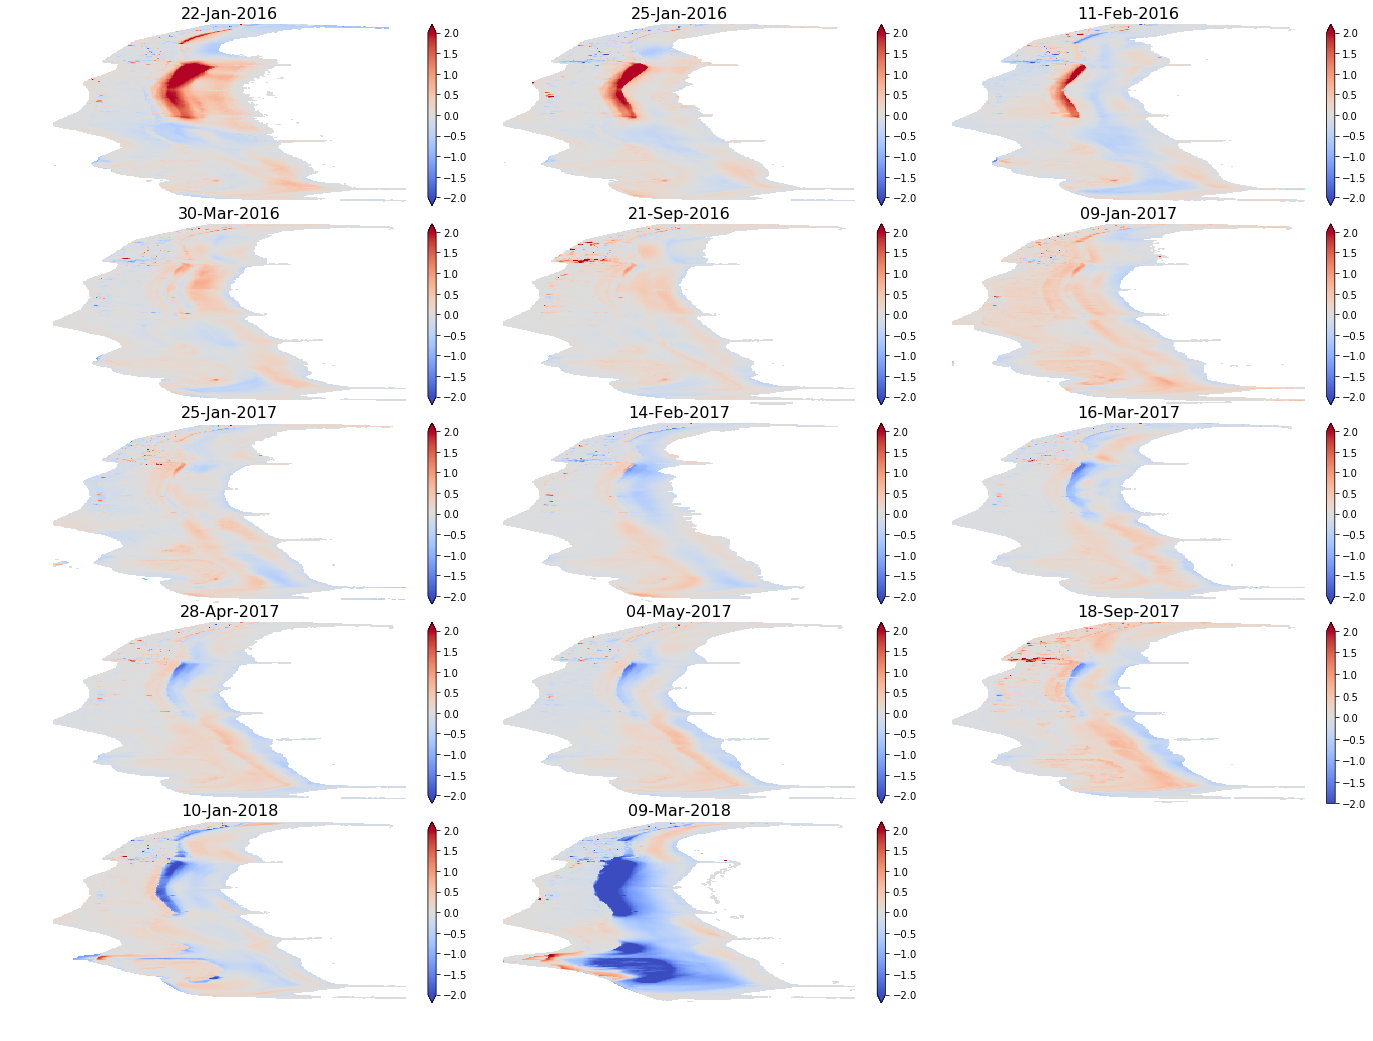

In [44]:
# look at anomoly
m = daanom.copy()
plt.subplots(figsize=(24,18))
plt.subplots_adjust(hspace=0.1, wspace=0.02)

for imapn in range(0,14):
    # small plots of elevation
    plt.subplot(5,3,imapn+1)
    plt.axis('off')
    mi = np.squeeze(m[imapn,:,:])
    mi.plot(vmin=-2,vmax=2,cmap=plt.cm.coolwarm)
    plt.title(titles[imapn],fontsize=16)
        
plt.savefig('anomoly_time_series.png')

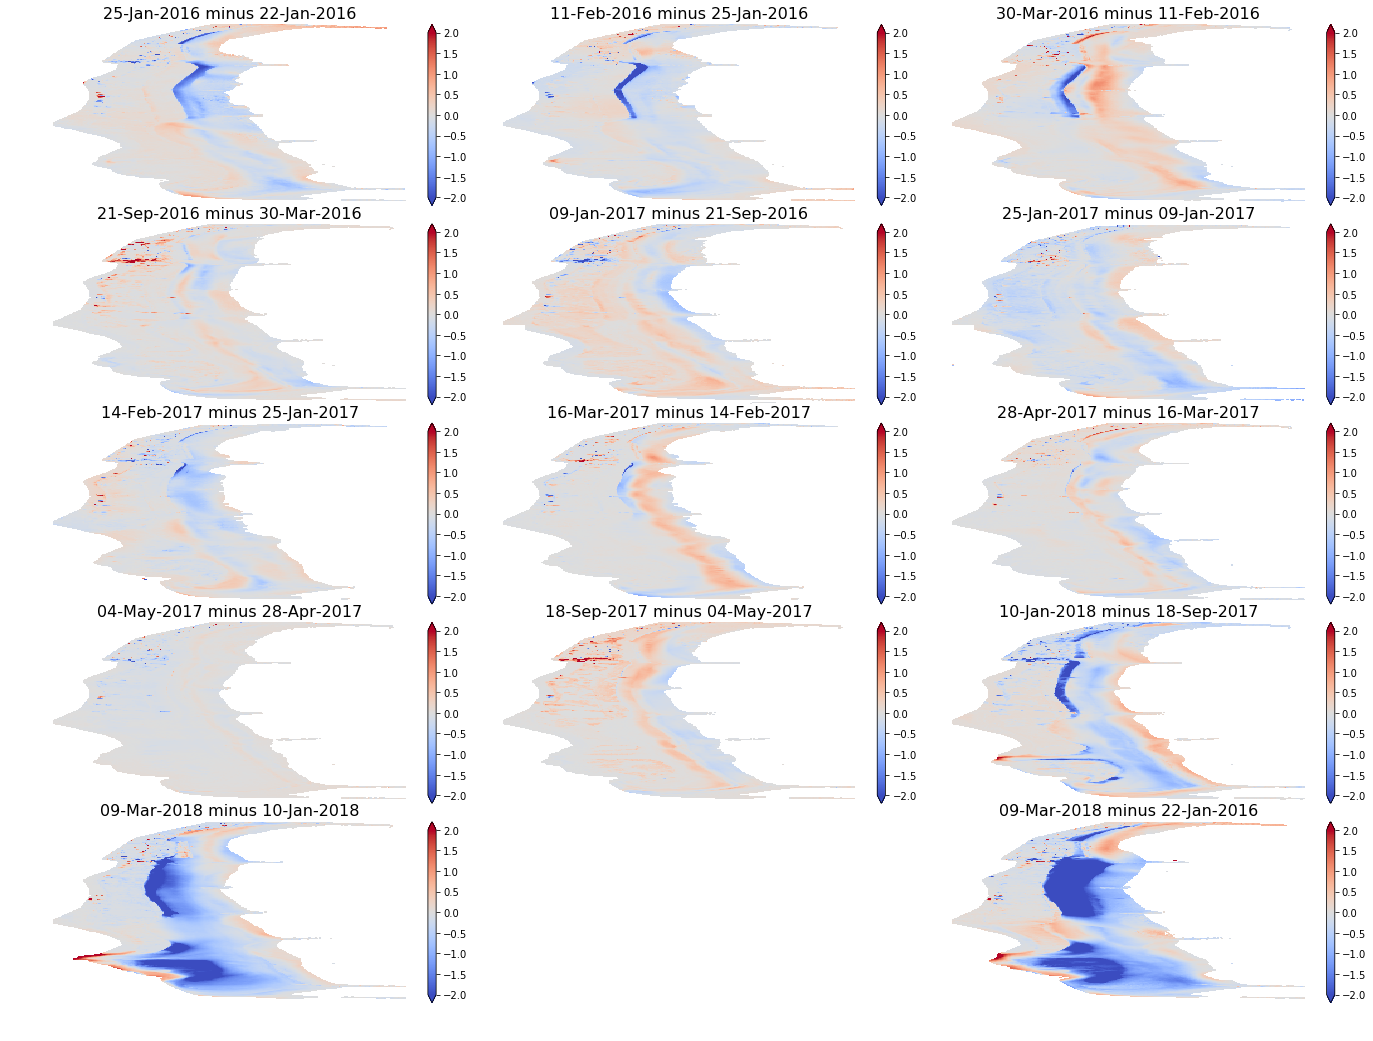

In [43]:
# look at difference maps
m = dadiff.copy()
plt.subplots(figsize=(24,18))
plt.subplots_adjust(hspace=0.1, wspace=0.02)
for imapn in range(0,13):
    # small plots of elevation
    plt.subplot(5,3,imapn+1)
    plt.axis('off')
    mi = np.squeeze(m[imapn,:,:])
    mi.plot(vmin=-2,vmax=2,cmap=plt.cm.coolwarm)
    plt.title(titles[imapn+1]+' minus '+titles[imapn], fontsize=16)

plt.subplot(5,3,15)
plt.axis('off')
mi = np.squeeze(m[13,:,:])
mi.plot(vmin=-2,vmax=2,cmap=plt.cm.coolwarm)
plt.title(titles[13]+' minus '+titles[0], fontsize=16)

plt.savefig('difference_time_series.png')

### Sum volumes across cross-shore transects

Start with:
```
dam[14,280,1300] - array of elevations, masked with NaNs outside ROI
```
Sum volumes over cross-shore transects. Result is:
```
amap[14,1300] - array of cross-shore sums
```
Sum in alongshore direction. Result is volume for each map.
```
amapsum[14]
```

In [72]:
# Sum volumes along cross-shore transects
# This places ones wherever there was valid elevation data.
# 1 happens to be the area of a pixel...if dx, dy are changed
# this needs to be multiplied by a scale factor when used to calculate area.
idam = dam.where(np.isnan(dam),1)

# amap = all volumes
amap = np.array(dam.sum(dim='Cross-shore'))
verr = 0.08
err = 1.96*np.sqrt(2.*verr**2)

eamap = np.array(dam.sum(dim='Cross-shore'))*verr
amapsum = np.sum(amap,1)
amaperrup = np.sum(amap+eamap,1)
amaperrdn = np.sum(amap-eamap,1)

print(np.shape(amapsum),np.shape(amaperrup))
print(err)
print(np.sum(amap,1))
print(np.sum(amap+err,1))

# bmap = beach volumes
idam = dam.where(np.isnan(beach),1)
ebmap = np.array(dam.sum(dim='Cross-shore'))*verr

bmap = np.array(beach.sum(dim='Cross-shore'))
bmapsum = np.sum(bmap,1)
bmaperrup = np.sum(bmap+ebmap,1)
bmaperrdn = np.sum(bmap-ebmap,1)

print(np.shape(bmapsum),np.shape(bmaperrup))
print(err)
print(np.sum(bmap,1))
print(np.sum(bmap+err,1))

# dmap = dune volumes
idam = dam.where(np.isnan(dune),1)
edmap = np.array(dam.sum(dim='Cross-shore'))*verr
dmap = np.array(dune.sum(dim='Cross-shore'))
dmapsum = np.sum(dmap,1)
dmaperrup = np.sum(dmap+edmap,1)
dmaperrdn = np.sum(dmap-edmap,1)

print(np.shape(dmapsum),np.shape(dmaperrup))
print(err)
print(np.sum(dmap,1))
print(np.sum(dmap+err,1))

(14,) (14,)
0.22174868658
[ 391370.01074842  380491.43204022  366514.87043744  373702.76702697
  377418.45853572  385901.53559593  366627.50969219  359138.29008698
  366967.68712481  367529.73374662  365419.9509861   379750.96277481
  358248.80478221  286287.86441491]
[ 391658.28404098  380779.70533278  366803.14372999  373991.04031952
  377706.73182827  386189.80888848  366915.78298474  359426.56337953
  367255.96041736  367818.00703918  365708.22427866  380039.23606737
  358537.07807477  286576.13770747]
(14,) (14,)
0.22174868658
[ 102195.84090184   92730.59813125   81958.66709808   78139.87892508
   79035.13101795   89966.64234029   78724.57624711   76093.69854951
   71955.82339797   72861.65005417   70949.88761546   78387.03743293
   58128.85305633       0.        ]
[ 102484.11419439   93018.8714238    82246.94039063   78428.15221763
   79323.4043105    90254.91563284   79012.84953966   76381.97184206
   72244.09669053   73149.92334673   71238.16090801   78675.31072548
   58417.126

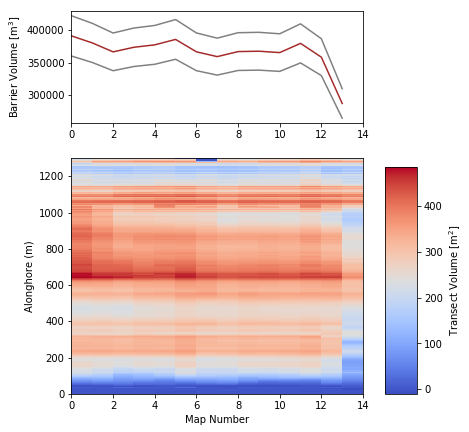

In [73]:
plt.subplots(figsize=(6,9))
plt.subplot(4,1,2)
plt.plot(amaperrup,'gray')
plt.plot(amaperrdn,'gray')
plt.plot(amapsum,'brown')

plt.ylabel('Barrier Volume [m$^3$]')
plt.xlim((0., 14))
plt.subplot(2,1,2)
plt.pcolormesh(amap.T,cmap=plt.cm.coolwarm )

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.xlabel('Map Number')
plt.ylabel('Alonghore (m)')
cax = plt.axes([0.85, 0.1, 0.075, 0.35])
plt.colorbar(cax=cax)
plt.ylabel('Transect Volume [m$^2$]')
plt.savefig('transect_volume.png',dpi=200)

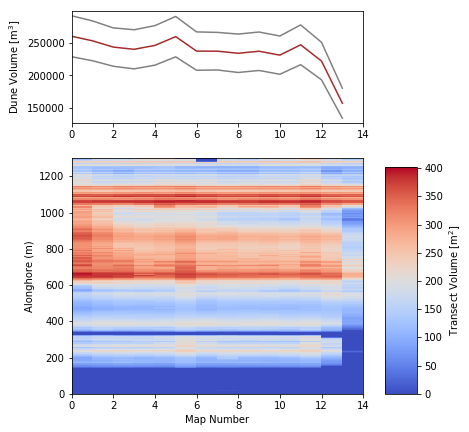

In [74]:
plt.subplots(figsize=(6,9))
plt.subplot(4,1,2)
plt.plot(dmaperrup,'gray')
plt.plot(dmaperrdn,'gray')
plt.plot(dmapsum,'brown')

plt.ylabel('Dune Volume [m$^3$]')
plt.xlim((0., 14))
plt.subplot(2,1,2)
plt.pcolormesh(dmap.T,cmap=plt.cm.coolwarm )

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.xlabel('Map Number')
plt.ylabel('Alonghore (m)')
cax = plt.axes([0.85, 0.1, 0.075, 0.35])
plt.colorbar(cax=cax)
plt.ylabel('Transect Volume [m$^2$]')
plt.savefig('transect_volume_dunes.png',dpi=200)

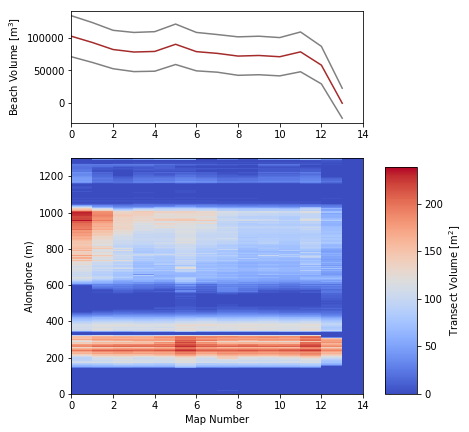

In [68]:
plt.subplots(figsize=(6,9))
plt.subplot(4,1,2)
plt.plot(bmaperrup,'gray')
plt.plot(bmaperrdn,'gray')
plt.plot(bmapsum,'brown')

plt.ylabel('Beach Volume [m$^3$]')
plt.xlim((0., 14))
plt.subplot(2,1,2)
plt.pcolormesh(bmap.T,cmap=plt.cm.coolwarm )

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.xlabel('Map Number')
plt.ylabel('Alonghore (m)')
cax = plt.axes([0.85, 0.1, 0.075, 0.35])
plt.colorbar(cax=cax)
plt.ylabel('Transect Volume [m$^2$]')
plt.savefig('transect_volume_beaches.png',dpi=200)

Shape of amap:  (14, 1300)
Shape of amap:  (14, 1300, 280)
Shape of diff(amap) (13, 1300)
Shape of amdiff:  (13, 1300)
Shape of amstd:  (1300, 280)


C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS3\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[]

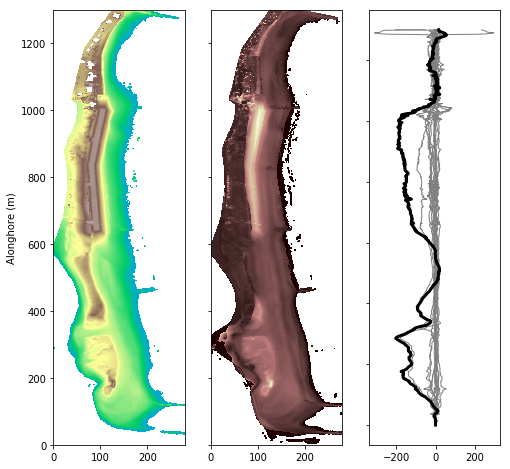

In [22]:
print("Shape of amap: ",np.shape(amap))
print("Shape of amap: ",np.shape(dam))

print("Shape of diff(amap)",np.shape(np.diff(amap,n=1,axis=0)) )
amdiff = np.diff(amap,n=1,axis=0)
amstd = np.squeeze(np.nanstd(dam,0))
print("Shape of amdiff: ",np.shape(amdiff))
print("Shape of amstd: ",np.shape(amstd))

fig, ax= plt.subplots(figsize=(8,8))
plt.subplot(1,3,1)
plt.pcolormesh(X, Y, np.squeeze(dam[0,:,:]), vmin=-2,vmax=8,cmap=plt.cm.terrain )
plt.ylabel('Alonghore (m)')

ax = plt.subplot(1,3,2)
plt.pcolormesh(X, Y, amstd, vmin=0, vmax = 2, cmap=plt.cm.pink )
ax.axes.get_yaxis().set_ticklabels([])

ax = plt.subplot(1,3,3)
plt.plot(amdiff.T,da.coords['Alongshore'].values,'gray',linewidth=1 )
plt.plot(np.sum(amdiff,0),da.coords['Alongshore'].values,'black',linewidth=3)
ax.axes.get_yaxis().set_ticklabels([])
plt.savefig('mapview_diffs.png',dpi=200)

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS3\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[]

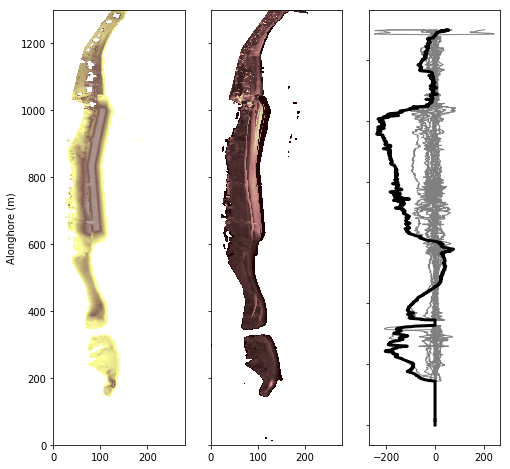

In [23]:
# dune only (does the map look weird?)
dmdiff = np.diff(dmap,n=1,axis=0)
dmstd = np.squeeze(np.nanstd(dune,0))

fig, ax= plt.subplots(figsize=(8,8))
plt.subplot(1,3,1)
plt.pcolormesh(X, Y, np.squeeze(dune[0,:,:]), vmin=-2,vmax=8,cmap=plt.cm.terrain )
plt.ylabel('Alonghore (m)')

ax = plt.subplot(1,3,2)
plt.pcolormesh(X, Y, dmstd, vmin=0, vmax = 2, cmap=plt.cm.pink )
ax.axes.get_yaxis().set_ticklabels([])

ax = plt.subplot(1,3,3)
plt.plot(dmdiff.T,da.coords['Alongshore'].values,'gray',linewidth=1 )
plt.plot(np.sum(dmdiff,0),da.coords['Alongshore'].values,'black',linewidth=3)
ax.axes.get_yaxis().set_ticklabels([])

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS3\lib\site-packages\numpy\lib\nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[]

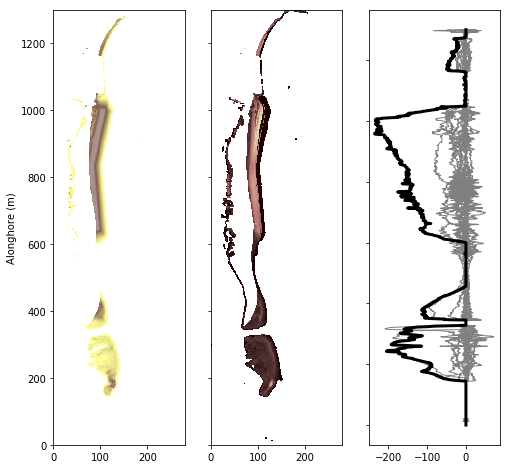

In [24]:
# beach only (does the map look weird?)
bmdiff = np.diff(bmap,n=1,axis=0)
bmstd = np.squeeze(np.nanstd(beach,0))

fig, ax= plt.subplots(figsize=(8,8))
plt.subplot(1,3,1)
plt.pcolormesh(X, Y, np.squeeze(beach[0,:,:]), vmin=-2,vmax=8,cmap=plt.cm.terrain )
plt.ylabel('Alonghore (m)')

ax = plt.subplot(1,3,2)
plt.pcolormesh(X, Y, bmstd, vmin=0, vmax = 2, cmap=plt.cm.pink )
ax.axes.get_yaxis().set_ticklabels([])

ax = plt.subplot(1,3,3)
plt.plot(bmdiff.T,da.coords['Alongshore'].values,'gray',linewidth=1 )
plt.plot(np.sum(bmdiff,0),da.coords['Alongshore'].values,'black',linewidth=3)
ax.axes.get_yaxis().set_ticklabels([])

#### this cell plots gain/loss as a line...I like the bars better
fig = plt.subplots(figsize=(12,12))
for i in range(0,13):
    ax = plt.subplot(3,5,i+1)
    #plt.plot(bmdiff.T,da.coords['Alongshore'].values )
    plt.plot(bmdiff[i,:],da.coords['Alongshore'].values,'black',linewidth=2)
    if not( i==0 or i==5 or i==10 ):
        ax.axes.get_yaxis().set_ticklabels([])
    plt.xlim(-150,150)

AttributeError: Unknown property rwidth

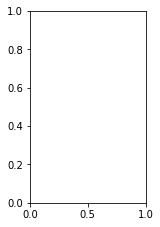

In [35]:
fig = plt.subplots(figsize=(12,12))
for i in range(13):
    colors = np.array([(1,0,0)]*1300)
    colors[amdiff[i,:] >= 0] = (0,0,1)
    ax=plt.subplot(3,5,i+1)
    ax.barh(da.coords['Alongshore'].values,amdiff[i,:],color=colors)
    plt.xlim(-150,150)
    plt.title(titles[i+1])
    if not( i==0 or i==5 or i==10 ):
        ax.axes.get_yaxis().set_ticklabels([])
        
colors = np.array([(1,0,0)]*1300)
colors[np.sum(amdiff,0) >= 0] = (0,0,1)
ax = plt.subplot(3,5,15)
ax.barh(da.coords['Alongshore'].values,np.sum(amdiff,0),color=colors)
#plt.title('Base Elevation ='+mel+' (m)')
plt.savefig('volume_change.png',dpi=200)


<BarContainer object of 1300 artists>

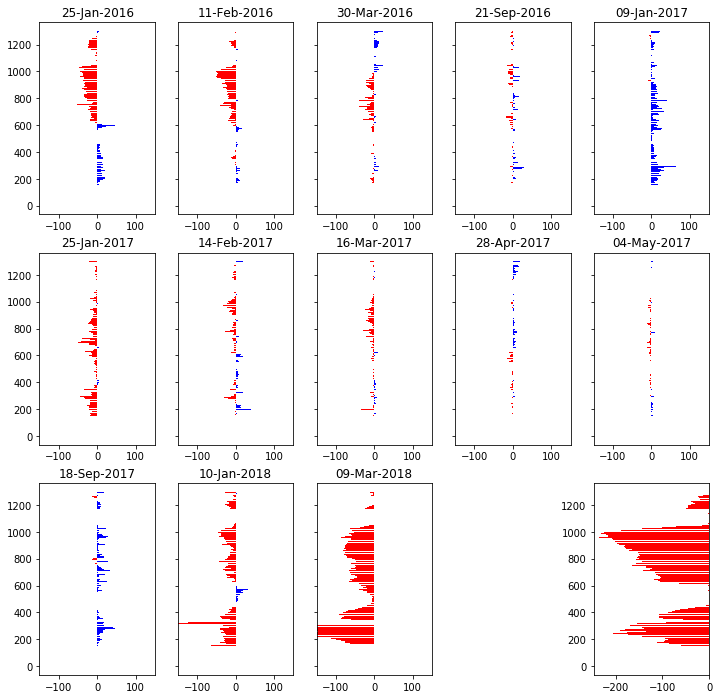

In [26]:
# do the same for the dune and beach
fig = plt.subplots(figsize=(12,12))
for i in range(13):
    colors = np.array([(1,0,0)]*1300)
    colors[bmdiff[i,:] >= 0] = (0,0,1)
    ax=plt.subplot(3,5,i+1)
    ax.barh(da.coords['Alongshore'].values,bmdiff[i,:],color=colors)
    plt.xlim(-150,150)
    plt.title(titles[i+1])
    if not( i==0 or i==5 or i==10 ):
        ax.axes.get_yaxis().set_ticklabels([])
        
colors = np.array([(1,0,0)]*1300)
colors[np.sum(bmdiff,0) >= 0] = (0,0,1)
ax = plt.subplot(3,5,15)
ax.barh(da.coords['Alongshore'].values,np.sum(bmdiff,0),color=colors)
#plt.title('Base Elevation ='+mel+' (m)')

(400, 600)

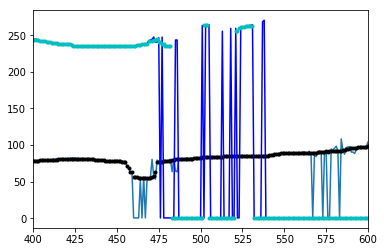

In [29]:
from scipy.ndimage.filters import maximum_filter1d, median_filter
xikf = np.zeros_like(xik)
median_filter(xik, 21, output=xikf, mode='nearest')
# try several filters...use the biggest values
xikbf7= np.ones_like(xik)
xikbf21= np.ones_like(xik)
xikbf51= np.ones_like(xik)

median_filter(xikb, 7, output=xikbf7, mode='nearest')
median_filter(xikb, 21, output=xikbf21, mode='nearest')
median_filter(xikb, 51, output=xikbf51, mode='nearest')
xikbf = np.max((np.hstack((xikbf7,xikbf21,xikbf51))),axis=1)

plt.plot(xik)
plt.plot(xikf,'.k')
plt.plot(xikb,'-b')
plt.plot(xikbf,'.c')
plt.xlim(400, 600)

In [30]:
np.shape(xikbf)

(1300,)

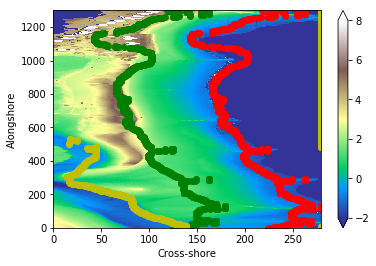

In [31]:
da.isel(map=imap).plot(vmin=-2,vmax=8,cmap=plt.cm.terrain)
plt.plot(280-xikf,y,'or')
plt.plot(180-xikf,y,'og')
plt.plot(280-xikbf,y,'oy')

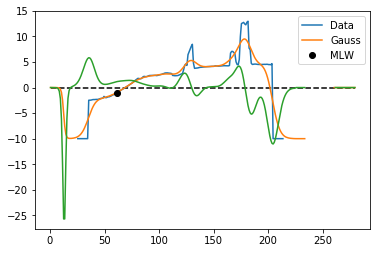

In [32]:
#   first point of points closest to MWL elevation (this does not work if an inland one is closer)
# mlw =  np.argmin(np.abs(t-MWLdatum))

fig, ax = plt.subplots()
plt.plot(x,np.zeros_like(x),'--k')
plt.plot(x,t,label='Data')
plt.plot(x,tsg,label='Gauss')
# plt.plot(x,tsb,label='Box')
plt.plot(x,10*dts)
#plt.plot(x,10*ddts)
plt.plot(x[kdx],t[kdx],'ok',label='MLW')
#plt.plot(x[mlwg],t[mlwg],'ob')
ax.legend()

In [33]:
xlimit = x<150.

inflection = abs(ddts)<1e2
print(np.argmax(t),np.argmax(tsg))

kdx = np.logical_and( np.logical_and(mlw,pos_slope), xlimit)

0 234


C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


NameError: name 'mlw' is not defined

In [ ]:
print(np.argmax(t),np.argmax(tsg),np.argmax(tsb))

In [ ]:
# why does this return two values?
# they are indices for rows, columns...even if the array is 1D
kdx = [0, 0, 0, 1, 0, 1, 0]
ii=np.where(kdx)
ii[0][0]

In [ ]:
aa = np.array((1,1,0,3,3,0,3,4,5,6,0,7,8,9,10))
bb = np.zeros_like(aa)
maximum_filter1d(aa, 5, output=bb, mode='nearest')
bb

In [ ]:
sum(xikf-xik)

In [ ]:
plt.plot(s)

In [ ]:
idx = np.where(m[:,:]>0.)

In [ ]:
np.shape(idx)